In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

# Suppress warnings 
import warnings
warnings.filterwarnings('ignore')

# Determine the optimal number of clusters in the data using gap statistics

## Imports

In [2]:
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from gap_statistic import OptimalK

import torch

from src.metrics.distribution_measures import Encoder
from src.data.dataset_updated import MakeDataLoader
from src.utils import get_device

## Configs

In [3]:
path_encoder = '../models/cVAE/parameter_state_dict_Encoder.pth'
# dataset parameters
folder_images = '/home/kinakh/Datasets/galaxy-zoo/images_training_rev1/'
file_labels = '/home/kinakh/Datasets/galaxy-zoo/training_solutions_rev1.csv'
size = 64
augmented = False
batch_size = 64

# cluster parameters
min_cluster = 2
max_cluster = 100

device = get_device()

## Load encoder

In [4]:
encoder = Encoder()
ckpt = torch.load(path_encoder)
res = encoder.load_state_dict(ckpt)
print(f'Loading: {res}')

encoder.to(device)
encoder.eval();

Loading: <All keys matched successfully>


## Load data

In [5]:
make_dl = MakeDataLoader(folder_images, file_labels, size, augmented=augmented)
dl = make_dl.get_data_loader_valid(batch_size=batch_size)

## Compute latents

In [6]:
latents = []


for images, _ in tqdm(dl):
    images = images.to(device)
    
    with torch.no_grad():
        mu, _ = encoder(images)
    latents.extend(mu.detach().cpu().numpy())
print(f'Number of latents: {len(latents)}')
latents = np.array(latents)

100%|██████████| 48/48 [00:06<00:00,  7.40it/s]

Number of latents: 3072


## Run gap statistics

In [7]:
def KMeans_clustering_func(X, k):
    """ 
    K Means Clustering function, which uses the K Means model from sklearn.
    
    These user-defined functions *must* take the X (input features) and a k 
    when initializing OptimalK
    """
    
    # Include any clustering Algorithm that can return cluster centers
    
    m = KMeans(random_state=11, n_clusters=k)
    m.fit(X)
    
    # Return the location of each cluster center,
    # and the labels for each point.
    return m.cluster_centers_, m.predict(X)

In [8]:
optimalK = OptimalK(clusterer=KMeans_clustering_func)

## Method 1. Taking the k maximizing the Gap value, which is calculated for each k

In [9]:
n_clusters = optimalK(latents, cluster_array=np.arange(min_cluster, max_cluster))
print('Optimal clusters: ', n_clusters)

Optimal clusters:  97


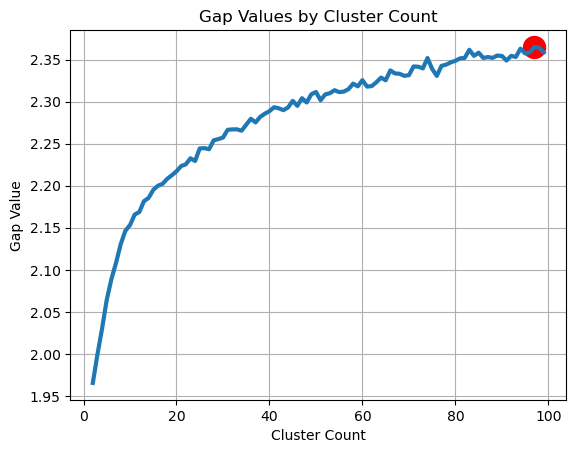

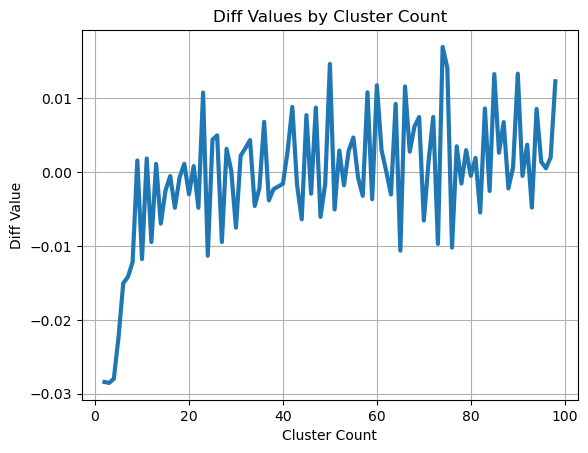

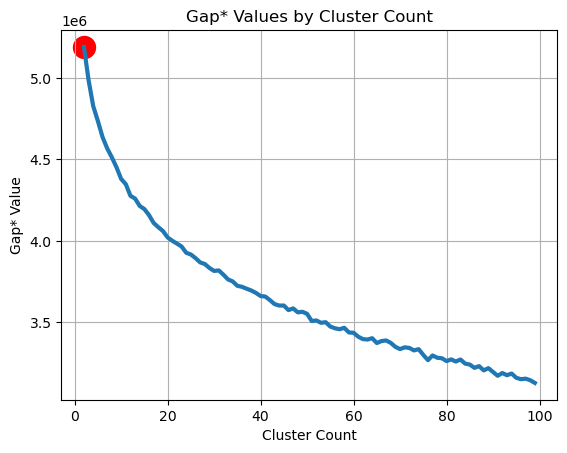

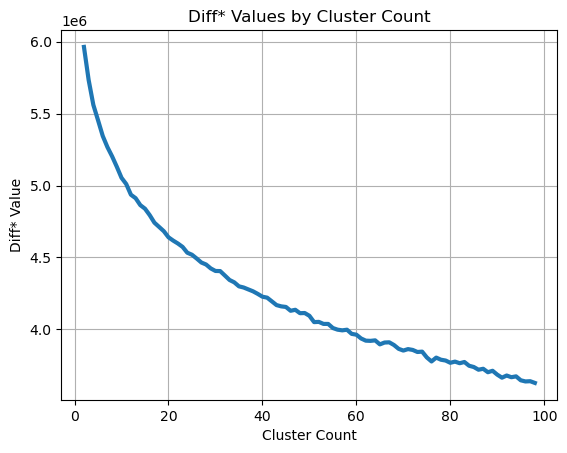

In [10]:
optimalK.plot_results()

## Method 2. Taking the smallest k such that Gap(k) >= Gap(k+1) - s(k+1).

In [11]:
df = optimalK.gap_df[['n_clusters', 'diff']]

In [12]:
df_sel = df[df['diff'] > 0]

In [13]:
print(f"Optimal number of clusters: {min(df_sel['n_clusters'])}")

Optimal number of clusters: 9.0


In [14]:
df = optimalK.gap_df

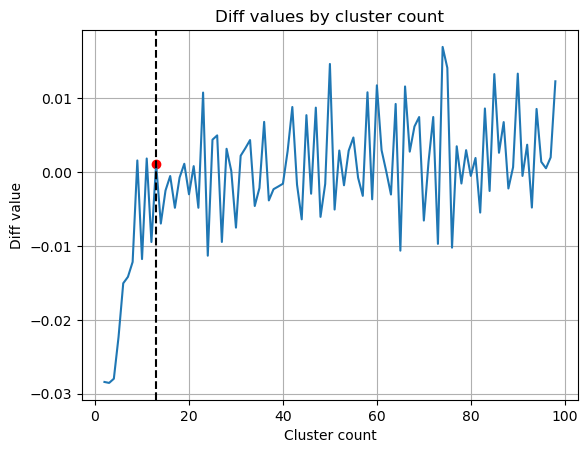

In [15]:
x_val = 13
y_val = df['diff'][11]

plt.figure()
plt.title('Diff values by cluster count')
plt.xlabel('Cluster count')
plt.ylabel('Diff value')
plt.plot(df['n_clusters'], df['diff'])
plt.scatter(x_val, y_val, color='r')
plt.axvline(x=x_val, linestyle='dashed', color='k')

plt.grid()

plt.savefig('diff_values_by_cluster_count.png', dpi=600)

## Method 3: Taking the k maximizing the Gap* value

In [16]:
gap_star = optimalK.gap_df['gap*'].values
n_clusters = optimalK.gap_df['n_clusters'].values

In [17]:
optimal_clusters = n_clusters[np.argmax(gap_star)]

In [18]:
print(f'Optimal number of clusters: {optimal_clusters}')

Optimal number of clusters: 2.0
